In [ ]:
# 프로젝트 회고
# 데이터 시각화를 통하여 얻는 기대효과를 표현했으면 좋았을 거 같다.
# 그래서 제일 핵심인 이탈률이 어디서 높은지 디테일한 부분보다 포괄적으로 어디서
# 한 눈에 시각화하여 이해하기 쉽나 알아보았다.

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling.profile_report as report

import re
import seaborn as sns
sns.set(style = 'white')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick # For specifying the axes tick format 

import warnings
warnings.filterwarnings('ignore')

# Label Encoding
from sklearn.preprocessing import LabelEncoder

# modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import StackingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import tensorflow as tf

C:\Users\Playdata\AppData\Local\Temp\ipykernel_14792\157151949.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling.profile_report as report


In [3]:
df = pd.read_csv('./모델링시작.csv', encoding='euc-kr')

In [6]:
df.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [8]:
df.columns

Index(['gender', 'age', 'married', 'number_of_dependents',
       'number_of_referrals', 'tenure_in_months', 'offer', 'phone_service',
       'avg_monthly_long_distance_charges', 'multiple_lines',
       'internet_service', 'internet_type', 'avg_monthly_gb_download',
       'online_security', 'online_backup', 'device_protection_plan',
       'premium_tech_support', 'streaming_tv', 'streaming_movies',
       'streaming_music', 'unlimited_data', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charge', 'total_charges',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'customer_status', 'tenure_in_years', 'churn'],
      dtype='object')

In [20]:
#범주가 두 개가 아닌 3개의 경우를 그리기 위해 가입기간에 따라 함수로 범주 구분
def classify_tenure_in_months(tenure):
    if tenure >= 0 and tenure < 12:
        return 0
    elif tenure >= 12 and tenure < 24:
        return 1
    elif tenure >=24 and tenure < 36:
        return 2
    elif tenure >= 36 and tenure < 60:
        return 3
    return 4
df['tenure_class'] = df['tenure_in_months'].apply(classify_tenure_in_months)
df['tenure_class'].value_counts().sort_index()

0    2069
1    1047
2     876
3    1568
4    1483
Name: tenure_class, dtype: int64

In [21]:
# 인사이트 도출 시 필요한 그래프를 그리기 위한 함수 생성
def graph_feature_churn_rate_by_class(col, classes, classes_desc, figsize=(6, 6), print_info=False):
    churned = []
    stayed = []
    for cls in classes:
        counts = df[df[col]==cls]["customer_status"].value_counts()
        churned.append(counts[1])
        stayed.append(counts[0])
    percent_churned = [f"{round(churned[i] / (churned[i] + stayed[i]) * 100, 0)}% churned" for i in range(len(classes))]
    plt.figure(figsize=figsize)
    bar1 = plt.bar(classes_desc, churned, color='dodgerblue')
    bar2 = plt.bar(classes_desc, stayed, bottom=churned, color='lightblue')
    plt.bar_label(bar2, percent_churned)
    plt.ylabel("Number of customers")
    plt.legend(["Churned", "Stayed"])
    plt.show()
    if print_info:
        print(churned, stayed, percent_churned)

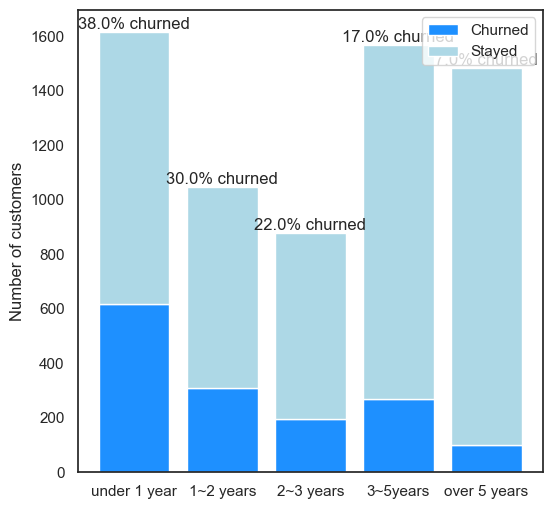

In [23]:
# 가입 기간에 따라 이탈률 시각화
graph_feature_churn_rate_by_class('tenure_class', [0,1,2,3,4],['under 1 year','1~2 years','2~3 years','3~5years','over 5 years'])

In [ ]:
# 이 부분이 찾아낸 문제점이라고 인식.(인사이트 도출)
# 영향력이 별로 없는 feature들을 뺀 결과 검증점수는 달라질 게 없었으며,
# 2년보다 적게 약정을 체결한 고객은 이탈률이 2년 약정을 하고 있는 고객들보다
# 상당히 높게 나온다.


In [ ]:
# 다른 기업의 통신사와 다른 업계도 조사하는
# 나이, 성별, 결혼여부,부양가족유무 등 기본적인 베이스를 피쳐로 돌려 알아보았다.